In [1]:
# The core libraries
import numpy as np
import pandas as pd
import sqlite3
# Visualization labraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# For data cleaning 
from datetime import datetime # For date parsing
import re   # For regular expressions (cleaning strings, removing symbols)
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Accessing the IMDb data
conn = sqlite3.connect("im.db")
df_IMDB_table = pd.read_sql("""
SELECT name 
FROM sqlite_master 
WHERE type = 'table'
;""",conn)

df_IMDB_table 

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers
8,cleaned_df_writers
9,cleaned_df_persons1


In [3]:
# We start by loading the table 
df_writers = pd.read_sql("""
SELECT *
FROM writers
;""",conn)
df_writers

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0438973,nm0175726
2,tt0438973,nm1802864
3,tt0462036,nm1940585
4,tt0835418,nm0310087
...,...,...
255868,tt8999892,nm10122246
255869,tt8999974,nm10122357
255870,tt9001390,nm6711477
255871,tt9004986,nm4993825


In [4]:
# Check the data types for standardization
df_writers.dtypes

movie_id     object
person_id    object
dtype: object

In [5]:
#checking for null values
df_writers.isnull().sum()

movie_id     0
person_id    0
dtype: int64

In [6]:
# Checking for duplicates
df_writers.duplicated().sum()

77521

In [7]:
#dropping duplicates
df_writers.drop_duplicates(inplace=True)

# Checking for duplicates
df_writers.duplicated().sum()

0

In [8]:
# Save your cleaned df_writers DataFrame as a SQL table
df_writers.to_sql("cleaned_df_writers", conn, if_exists="replace", index=False)

178352

In [9]:
# We start by loading the table 
df_persons = pd.read_sql("""
SELECT *
FROM persons
;""",conn)
df_persons

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator"
...,...,...,...,...,...
606643,nm9990381,Susan Grobes,NaN,NaN,actress
606644,nm9990690,Joo Yeon So,NaN,NaN,actress
606645,nm9991320,Madeline Smith,NaN,NaN,actress
606646,nm9991786,Michelle Modigliani,NaN,NaN,producer


In [10]:
df_persons.isnull().sum()

person_id                  0
primary_name               0
birth_year            523912
death_year            599865
primary_profession     51340
dtype: int64

In [11]:
# The most noticeable thing is the mssing data in the birth and death year columns
# Lets check the percentage of missing data
(df_persons.isnull().sum()/len(df_persons)) * 100 

person_id              0.000000
primary_name           0.000000
birth_year            86.361778
death_year            98.881889
primary_profession     8.462898
dtype: float64

In [12]:
#  With 86% and 98% missing data, its best to drop the two columns
df_persons1 = df_persons.drop(['birth_year','death_year'], axis=1)
df_persons1.isna().sum()

person_id                 0
primary_name              0
primary_profession    51340
dtype: int64

In [13]:
# Considering that only 8% of the primary profession column is missing we can fill it in using the mode
df_persons1['primary_profession'] = df_persons1['primary_profession'].fillna(df_persons1['primary_profession'].mode()[0])
# Check of the changes took
df_persons1.isna().sum()

person_id             0
primary_name          0
primary_profession    0
dtype: int64

In [14]:
# Save your cleaned df_persons1 DataFrame as a SQL table
df_persons1.to_sql("cleaned_df_persons1", conn, if_exists="replace", index=False)

606648

In [15]:
conn= sqlite3.connect("im.db")
merged_ratings_writers = pd.read_sql("""
SELECT primary_name, averagerating, numvotes
FROM cleaned_df_writers AS w
LEFT JOIN movie_ratings AS r ON r.movie_Id = w.movie_Id
LEFT JOIN cleaned_df_persons1 AS p ON p.person_Id = w.person_Id
GROUP BY primary_name
ORDER BY averagerating DESC
LIMIT 20;
""", conn)
merged_ratings_writers

,primary_name,averagerating,numvotes
0,Mohamed Ulad-Mohand,10.0,5
1,Loreto Di Cesare,10.0,8
2,Ivana Diniz,10.0,5
3,Heather Augustyn,10.0,5
4,Emre Oran,10.0,6
5,Daniel Alexander,10.0,5
6,Cristina Duarte,10.0,5
7,Brian Baucum,10.0,8
8,Ana Beatriz Nogueira,10.0,5
9,Vyacheslav Bihun,9.8,28


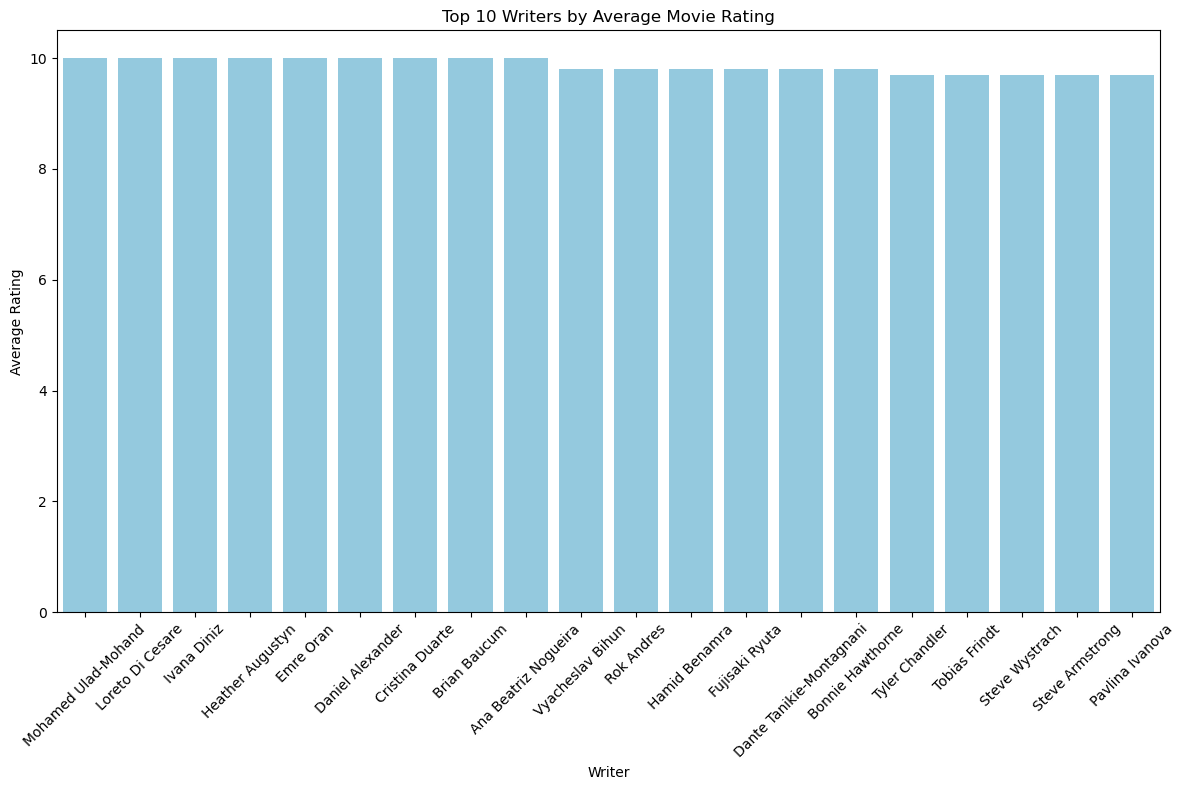

In [16]:
#Plotting a bar graph
plt.figure(figsize=(12, 8))
sns.barplot(data=merged_ratings_writers, y='averagerating', x='primary_name', color='skyblue')

plt.ylabel('Average Rating')
plt.xlabel('Writer')
plt.title('Top 10 Writers by Average Movie Rating')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
conn= sqlite3.connect("im.db")
merged_ratings_writers = pd.read_sql("""
SELECT primary_name, averagerating, numvotes
FROM cleaned_df_writers AS w
LEFT JOIN movie_ratings AS r ON r.movie_Id = w.movie_Id
LEFT JOIN cleaned_df_persons1 AS p ON p.person_Id = w.person_Id
WHERE averagerating IS NOT NULL
GROUP BY primary_name
ORDER BY averagerating ASC
LIMIT 20;
""", conn)
merged_ratings_writers

,primary_name,averagerating,numvotes
0,Akiko Amy Kanda,1.0,449
1,Alexey Voorhis,1.0,19
2,Ayako Yamaguchi,1.0,439
3,Ayumu Hasegawa,1.0,126
4,Azhari Mohd Zain,1.0,674
5,Azlan Syah,1.0,674
6,Chang-Kun Mei,1.0,96
7,Chia-lin Chu,1.0,6
8,Eigo Motozawa,1.0,489
9,Erik Alarik,1.0,8


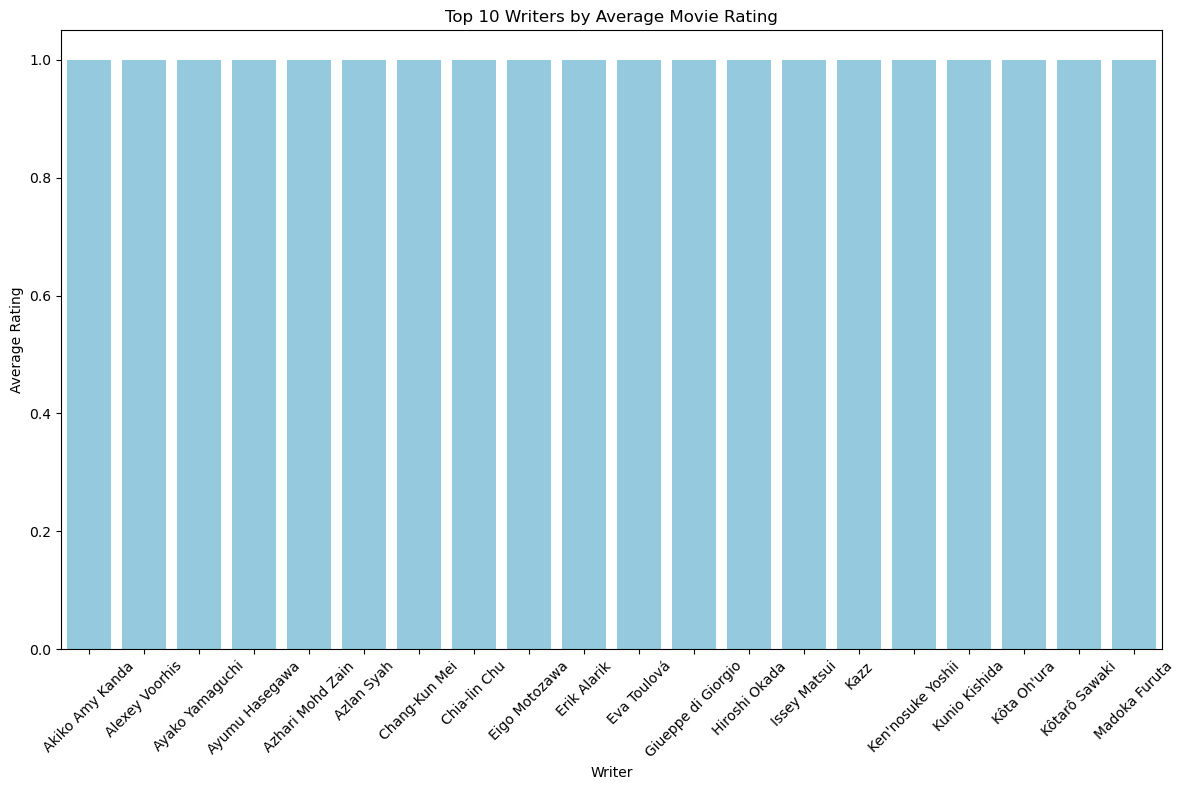

In [18]:
#Plotting a bar graph
plt.figure(figsize=(12, 8))
sns.barplot(data=merged_ratings_writers, y='averagerating', x='primary_name', color='skyblue')

plt.ylabel('Average Rating')
plt.xlabel('Writer')
plt.title('Top 10 Writers by Average Movie Rating')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()